In [66]:
import pandas as pd
import numpy as np
import tensorflow as tf
import zipfile

import warnings
warnings.filterwarnings('ignore')

In [67]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [69]:
with zipfile.ZipFile("train.zip", "r") as zip_ref:
    zip_ref.extractall("train")

# Unzip test.zip
with zipfile.ZipFile("test1.zip", "r") as zip_ref:
    zip_ref.extractall("test")

In [71]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# For training set
training_set = datagen.flow_from_directory(
    "train",
    target_size=(64, 64),
    batch_size=32,
    class_mode="binary"
)

# For test set
test_set = datagen.flow_from_directory(
    "test",
    target_size=(64, 64),
    batch_size=32,
    class_mode=None,  # Since it's a test set, no labels are needed
    shuffle=False  # To maintain the order of the files
)

Found 25000 images belonging to 1 classes.
Found 12500 images belonging to 1 classes.


In [73]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense

In [74]:
from tensorflow.keras.regularizers import l2

In [75]:
cnn = tf.keras.models.Sequential()

In [76]:
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

In [77]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [78]:
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [79]:
cnn.add(tf.keras.layers.Flatten())

In [80]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

In [81]:
cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear'))

In [82]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [83]:
cnn.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

In [85]:
r=cnn.fit(x = training_set, validation_data = test_set, epochs = 15)

Epoch 1/15


782/782 [==============================] - 171s 214ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 4.6828e-04 - val_accuracy: 1.0000
Epoch 2/15
782/782 [==============================] - 120s 153ms/step - loss: 2.0406e-04 - accuracy: 1.0000 - val_loss: 1.1656e-04 - val_accuracy: 1.0000
Epoch 3/15
782/782 [==============================] - 129s 165ms/step - loss: 6.9490e-05 - accuracy: 1.0000 - val_loss: 3.4103e-04 - val_accuracy: 1.0000
Epoch 4/15
782/782 [==============================] - 124s 158ms/step - loss: 1.1798e-04 - accuracy: 1.0000 - val_loss: 2.1771e-05 - val_accuracy: 1.0000
Epoch 5/15
782/782 [==============================] - 119s 152ms/step - loss: 6.6673e-06 - accuracy: 1.0000 - val_loss: 7.5625e-07 - val_accuracy: 1.0000
Epoch 6/15
782/782 [==============================] - 118s 151ms/step - loss: 2.2610e-04 - accuracy: 1.0000 - val_loss: 2.3490e-04 - val_accuracy: 1.0000
Epoch 7/15
782/782 [==============================] - 117s 150ms/step - loss: 

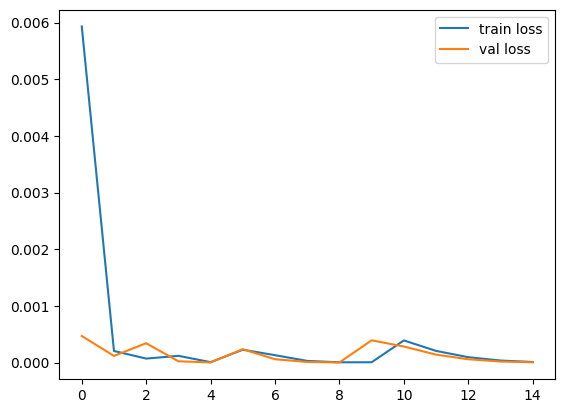

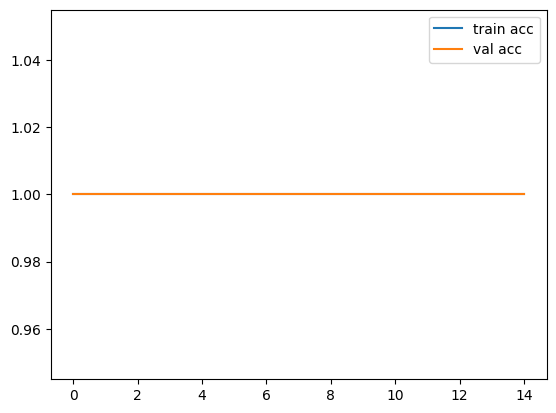

In [86]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [87]:
from tensorflow.keras.models import load_model

cnn.save('./model_rcat_dog.h5')

In [91]:
from tensorflow.keras.preprocessing import image
test_image = image.load_img('test/test1/1.jpg', target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)

1/1 [==============================] - 1s 734ms/step


In [92]:
if result[0]<0:
    print("The image classified is cat")
else:
    print("The image classified is dog")

The image classified is cat


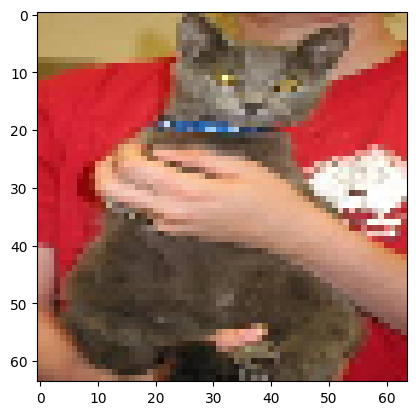

1/1 [==============================] - 0s 29ms/step
Prediction: cat


In [103]:
import random
import matplotlib.pyplot as plt

# Load 10 random images from the test set
random_test_samples = random.sample(test_set.filenames, 1)

for filename in random_test_samples:
    # Load and display the image
    img_path = os.path.join("test", filename)
    img = image.load_img(img_path, target_size=(64, 64))
    plt.imshow(img)
    plt.show()

    # Preprocess the image for prediction
    test_image = image.load_img(img_path, target_size=(64, 64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image = test_image / 255

    # Predict the class
    result = cnn.predict(test_image)
    if result[0][0] > 0.5:
        prediction = 'dog'
    else:
        prediction = 'cat'
    
    print(f"Prediction: {prediction}")
